In this Notebook, we go through some differential equation examples and how to solve them using neural networks

## PDE: Difussion Equation

$$
\frac{\partial g(x,t)}{\partial t} = \frac{\partial^2 g(x,t)}{\partial x^2}
$$


$$
\begin{align*}
g(0,t) &= 0 ,\qquad t \geq 0 \\
g(1,t) &= 0, \qquad t \geq 0 \\
g(x,0) &= u(x),\qquad x\in [0,1]
\end{align*}
$$

with $u(x) = \sin(\pi x)$

In [1]:
import torch
import torch.nn as nn
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(1, 10)
        self.output_layer1 = nn.Linear(10, 1)
        self.hidden_layer2 = nn.Linear(1, 10)
        self.output_layer2 = nn.Linear(10, 1)
        self.output_layer = nn.Linear(2, 1)

    def forward(self, x, t):
        #inputs = torch.cat([x,t],axis=1)
        layer_out = torch.sigmoid(self.hidden_layer1(x))
        output1 = self.output_layer1(layer_out)
        layer_out = torch.sigmoid(self.hidden_layer2(t))
        output2 = self.output_layer2(layer_out)
        #output = output.reshape(100, 100)
        output = torch.cat([output1,output2],axis=1)
        output = self.output_layer(output)
        return output

/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

def u(x):
    return torch.sin(torch.pi*x)


def exact_func(point):
    x, t = point
    return torch.exp(-torch.pi**2*t)*torch.sin(torch.pi*x)


def loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    y = model(x, t)

    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y.sum(), t, create_graph=True)[0]    
    dy_d2x = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]
        
    MSEf = torch.mean((dy_dt - dy_d2x)**2) #MSEf

    x_zeros = torch.zeros_like(x)
    y0 = model(x_zeros, t)
    x_ones = torch.ones_like(x)
    y1 = model(x_ones, t)
    bc1 = (y0 - x_zeros)**2 #MSEu1
    bc2 = (y1 - x_zeros)**2 #MSEu2
    
    t_zeros = torch.zeros_like(t)
    yx = model(x, t_zeros)

    bc3 = (yx - u(x))**2 #MSEu3
    return  MSEf + bc1.sum() + bc2.sum() + bc3.sum()


# Build some random data points
Nt = 10
Nx = 10
x = torch.linspace(0, 1, Nx)[:, None]
t = torch.linspace(0, 1, Nt)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x, t)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x, t).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x, t).item())

Epoch 1 , Loss:  21.998546600341797
Epoch 2 , Loss:  2.610840082168579
Epoch 3 , Loss:  1.905149221420288
Epoch 4 , Loss:  1.7962307929992676
Epoch 5 , Loss:  1.7672207355499268
Epoch 6 , Loss:  1.7373145818710327
Epoch 7 , Loss:  1.7297943830490112
Epoch 8 , Loss:  1.7184910774230957
Epoch 9 , Loss:  1.7120616436004639
Epoch 10 , Loss:  1.7083091735839844
Final Loss:  1.7067139148712158


In [7]:
def exact_func(point):
    x, t = point
    return torch.exp(-torch.pi**2*t)*torch.sin(torch.pi*x)

Nx = 10
Nt = 10
x = torch.linspace(0, 1, Nx)[:, None]
t = torch.linspace(0, 1, Nt)[:, None]

## Store the results
g_dnn_ag = torch.zeros((Nx, Nt))
G_analytical = torch.zeros((Nx, Nt))
for i,x_ in enumerate(x):
    for j, t_ in enumerate(t):
        point = torch.tensor([x_, t_])
        G_analytical[i,j] = exact_func(point)
        
with torch.no_grad():
    ypred = model(x, t)
ypred = ypred.squeeze()

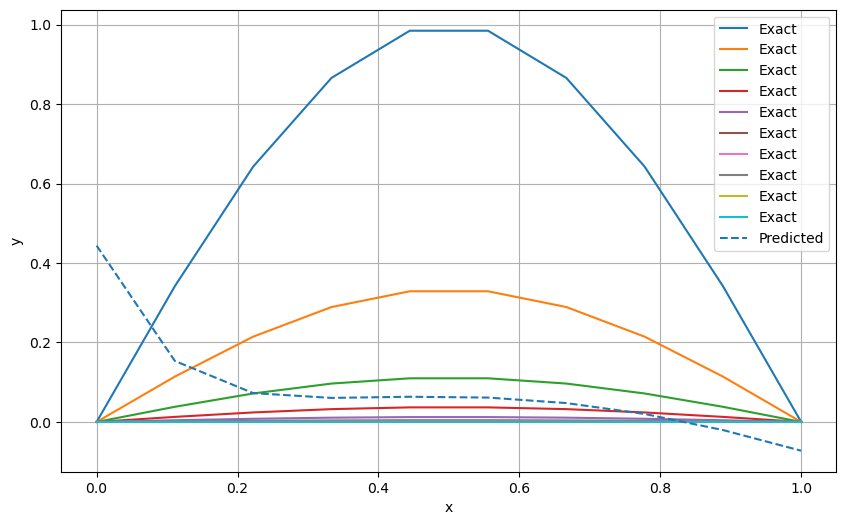

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(x, G_analytical, label="Exact")
plt.plot(x, ypred, '--' ,label="Predicted")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()